In [1]:
import re
import datasets
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from matplotlib.ticker import MaxNLocator

In [2]:
os.chdir('..')

In [3]:
from src.template import template_matching

First, we load the e-SNLI dataset as well all model evaluations

In [4]:
esnli = datasets.load_dataset("esnli")

Found cached dataset esnli (/Users/lorenzorota/.cache/huggingface/datasets/esnli/plain_text/0.0.2/a160e6a02bbb8d828c738918dafec4e7d298782c334b5109af632fec6d779bbc)


  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
all_results = pd.read_csv('results/allResults.csv')

In [6]:
all_results_custom = pd.read_csv('results/allResults-custom.csv')

Here we do a bit of dataset preprocessing so we can using the `template_matching` function

In [7]:
labels_dict = {
    0 : "entailment",
    1 : "neutral",
    2 : "contradiction"
}

In [8]:
esnli_train_df = pd.DataFrame(esnli['train'])

In [9]:
esnli_train_df['label'] = esnli_train_df['label'].map(labels_dict)

Now we generate the template matching statistics for the training set explanations and all model predictions

In [10]:
stats_training_data = template_matching(esnli_train_df['premise'], esnli_train_df['hypothesis'], esnli_train_df['label'], esnli_train_df['explanation_1'], 13)
stats_exp = template_matching(all_results['premise'], all_results['hypothesis'], all_results['label'], all_results['rug-nlp-nli/flan-base-nli-explanation_prediction'], 13)
stats_label_exp = template_matching(all_results['premise'], all_results['hypothesis'], all_results['label'], all_results['rug-nlp-nli/flan-base-nli-label-explanation_prediction'].str.split(n=1).str[1], 13)
stats_exp_custom = template_matching(all_results_custom['premise'], all_results_custom['hypothesis'], all_results_custom['label'], all_results_custom['rug-nlp-nli/flan-base-nli-explanation-custom_prediction'], 13)
stats_label_exp_custom = template_matching(all_results_custom['premise'], all_results_custom['hypothesis'], all_results_custom['label'], all_results_custom['rug-nlp-nli/flan-base-nli-label-explanation-custom_prediction'].str.split(n=1).str[1], 13)

We then implement a function to visualize the template matching distribution as a stacked bar chart

In [11]:
def visualize(class_name, save=False):
    """Create visual chart of template matching distribution"""
    
    unsorted_train = [(importance, feature) for feature, importance in 
                      zip(stats_training_data['distribution'][class_name].keys(), stats_training_data['distribution'][class_name].values())]
    sorted_train = sorted(unsorted_train)
    sorted_train = sorted_train[::-1]
    
    keys_train = []
    values_train = []

    for i in sorted_train:
        keys_train += [i[1]]
        values_train += [i[0]]

    values_label_exp = np.array([stats_label_exp['distribution'][class_name][i] for i in keys_train])
    values_label_exp_custom = np.array([stats_label_exp_custom['distribution'][class_name][i] for i in keys_train])
    values_exp = np.array([stats_exp['distribution'][class_name][i] for i in keys_train])
    values_exp_custom = np.array([stats_exp_custom['distribution'][class_name][i] for i in keys_train])

    ind = np.arange(len(keys_train))
    fig, ax = plt.subplots()

    plt.title(f"Distribution of {class_name} template matches", fontsize=15)
    plt.ylabel("Number of matches", fontsize=13)

    plt.bar(ind, values_train, color="C0", label="train")
    plt.bar(ind, values_label_exp, color="C1", bottom=values_train, label="label-exp")
    plt.bar(ind, values_label_exp_custom, color="C2", bottom=values_train+values_label_exp, label="label-exp-custom")
    plt.bar(ind, values_exp, bottom=values_train+values_label_exp+values_label_exp_custom,color="C3", label="exp")
    plt.bar(ind, values_exp_custom, bottom=values_train+values_label_exp+values_label_exp_custom+values_exp ,color="C4", label="exp-custom")

    plt.legend(loc='upper right')
    
    plt.xticks(range(len(values_train)), keys_train)
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    if save:
        plt.savefig(f'{class_name}-template-distribution.pdf', bbox_inches='tight')
    plt.show()


Now we can generate stacked bar charts for all the different types of templates

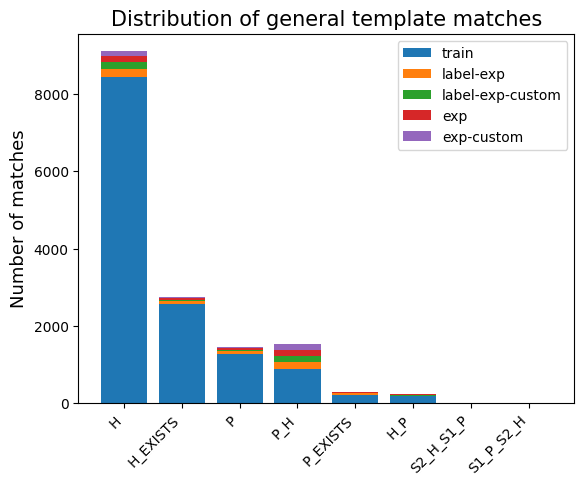

In [16]:
visualize('general')

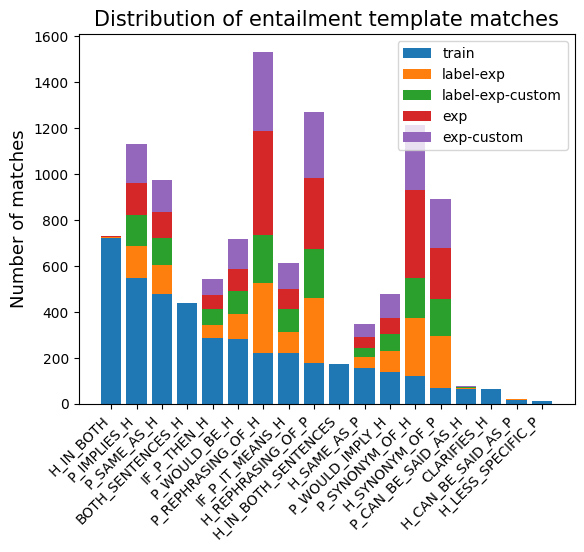

In [17]:
visualize('entailment')

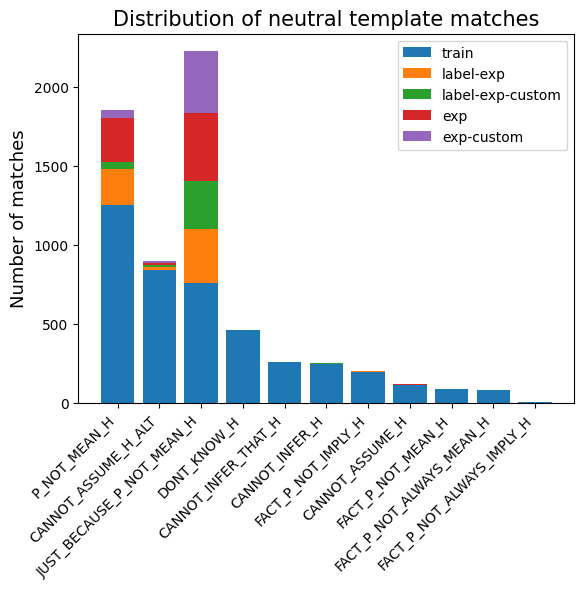

In [18]:
visualize('neutral')

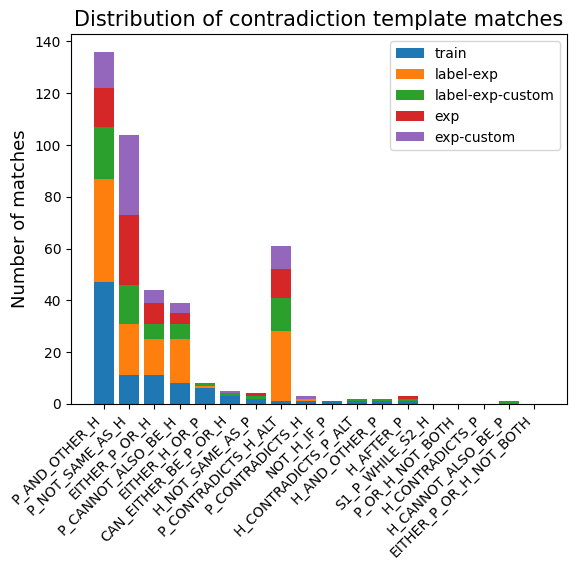

In [19]:
visualize('contradiction')

The final thing that we will look at, is the number of template matches per class over varying cutoff values

In [54]:
def compute_and_visualize_total_matches(cutoffs, save=False):
    """Generate bar charts of total template matches using different cutoff values"""
    
    matches = []
    for val in cutoffs:
        matches.append(template_matching(esnli_train_df['premise'], esnli_train_df['hypothesis'], esnli_train_df['label'], esnli_train_df['explanation_1'], val))

    width = 1/len(cutoffs)
    X_axis = np.arange(len(matches[0]['count']))

    plt.figure()
    for idx, match in enumerate(matches):
        plt.bar(X_axis + width*idx, match['count'].values(), width=width, label=f'cutoff={cutoffs[idx]}')
    plt.xticks(X_axis + width, list(matches[0]['count'].keys()))
    plt.legend(loc='upper right')
    plt.title(f'Total number of template matches per class')
    plt.ylabel("Number of matches")
    if save:
        plt.savefig(f'total-matches.pdf', bbox_inches='tight')
    plt.show()

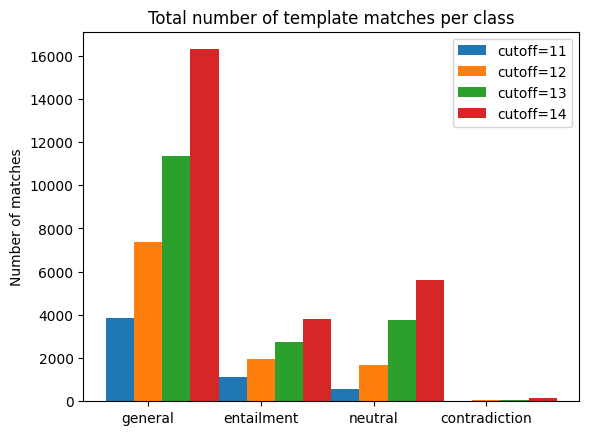

In [58]:
compute_and_visualize_total_matches([11,12,13,14])